In [1]:
import sys
import os
from tensorflow.keras.models import load_model
import joblib
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt


module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import add_growth_score_based_on_main_features, add_repo_age_days_col, add_days_since_last_release_col, convert_topics_to_embeddings, indexify_release_dates, add_lag_features_based_on_target, scale_final_data, remove_outliers, reduce_dimentionality_pca, forecast_growth, get_single_repo_data, remove_unwanted_features, distribute_features_across_releases, apply_time_based_noise, apply_proportional_noise, remove_first_augmented_rows
import numpy as np

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)
from config import GITHUB_TOKEN



/opt/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
test_df = get_single_repo_data('https://github.com/tensorflow/tensorflow', GITHUB_TOKEN)

test_df.head()

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
0,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-22T23:46:28Z,v2.17.0,2024-07-11T16:28:57Z,30,4909,35793,185682,74189,185682
1,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-22T23:46:28Z,v2.17.0-rc1,2024-07-02T04:17:28Z,30,4909,35793,185682,74189,185682
2,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-22T23:46:28Z,v2.16.2,2024-06-28T18:56:30Z,30,4909,35793,185682,74189,185682
3,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-22T23:46:28Z,v2.17.0-rc0,2024-06-18T20:41:46Z,30,4909,35793,185682,74189,185682
4,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-22T23:46:28Z,v2.15.1,2024-03-08T19:09:29Z,30,4909,35793,185682,74189,185682


In [3]:
df_exploded = test_df 
# Ascending order of release date
df_exploded = df_exploded.sort_values(by='release_date', ascending=True).reset_index(drop=True)


#Data Augmentation
# Distribute each column across the release dates
df_augmented = distribute_features_across_releases(df_exploded, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues', 'num_releases'])
df_augmented = apply_time_based_noise(df_augmented, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues'])
df_augmented = apply_proportional_noise(df_augmented, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues'])
df_augmented = remove_first_augmented_rows(df_augmented)

test_df = df_augmented

test_df = add_growth_score_based_on_main_features(test_df, train=False)
actual_growth_score = test_df['growth_score']
test_df = add_repo_age_days_col(test_df)

test_df = add_days_since_last_release_col(test_df)
test_df = convert_topics_to_embeddings(test_df)
test_df = remove_outliers(test_df)
test_df = indexify_release_dates(test_df)

test_df = add_lag_features_based_on_target(test_df)

X = remove_unwanted_features(test_df)
X_scaled = scale_final_data(X=X.values)
X_scaled_pca = reduce_dimentionality_pca(X_scaled)

n_features_scaled = X_scaled_pca.shape[1] 
n_timesteps = 2
test_generator = TimeseriesGenerator(X_scaled_pca, np.zeros(len(X_scaled_pca)), length=n_timesteps, batch_size=1)


model = load_model('../models/best_rnn_model.keras')

# Use the updated model for prediction
y_pred = model.predict(test_generator)

print(f'predicted: {y_pred[0][0]}', f' | actual: {actual_growth_score[1]}')

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
0,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-22T23:46:28Z,v2.11.0-rc2,2022-11-02T16:59:54Z,1,676,5526,26445,8743,24117
1,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-22T23:46:28Z,v2.8.4,2022-11-16T19:22:47Z,2,1282,9850,50704,19765,51367
2,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-22T23:46:28Z,v2.9.3,2022-11-16T19:57:28Z,3,2005,13521,74059,26797,73231
3,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-22T23:46:28Z,v2.10.1,2022-11-16T20:31:35Z,4,2327,18434,91447,37628,87099
4,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-22T23:46:28Z,v2.11.0,2022-11-18T06:01:33Z,5,2804,22018,120015,44682,106966


In [6]:
# from tensorflow.keras.models import load_model, Model
# from tensorflow.keras.layers import Dense, LSTM, Dropout, Reshape, Input
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# import tensorflow as tf
# import random
# import joblib
# import numpy as np

# # Set random seeds for reproducibility
# seed = 42
# np.random.seed(seed)
# tf.random.set_seed(seed)
# random.seed(seed)

# # Preprocess the test data
# X = remove_unwanted_features(test_df)
# X_scaled = scale_final_data(X=X.values)
# X_scaled_pca = reduce_dimentionality_pca(X_scaled)

# n_features = X_scaled_pca.shape[1]

# # Set n_timesteps to 5 as required by the base model
# n_timesteps = 4
# test_generator = TimeseriesGenerator(X_scaled_pca, np.zeros(len(X_scaled_pca)), length=n_timesteps, batch_size=1)

# # Load the base model
# base_model = load_model('../models/best_rnn_model.keras')
# base_model.summary()

# # Define a new input layer with the expected shape
# input_shape = (n_timesteps, n_features)
# new_input = Input(shape=input_shape)

# # Call the base model with the new input
# # Note: We're calling `base_model` directly with the new input now
# base_output = base_model(new_input)

# # Get the LSTM layer output from the base model
# base_lstm_output = base_model.get_layer('lstm_17').output

# # Create an intermediate model
# intermediate_model = Model(inputs=base_model.input, outputs=base_lstm_output)

# # Freeze layers in the base model
# for layer in base_model.layers:
#     layer.trainable = False

# # Call the intermediate model with the new input
# base_lstm_features = intermediate_model(new_input)
# print(f'Base Output Shape: {base_lstm_features.shape}')

# # Check the total number of elements in the base output
# total_elements = base_lstm_features.shape[-1]
# print(f'Total Elements: {total_elements}')

# # Ensure the reshape dimensions are compatible
# new_feature_size = total_elements // n_timesteps

# if total_elements % n_timesteps != 0:
#     raise ValueError(f"Cannot reshape base output of size {total_elements} into ({n_timesteps}, -1).")

# # Reshape the base output for LSTM input
# reshaped_output = Reshape((n_timesteps, new_feature_size))(base_lstm_features)

# # Add LSTM and custom layers
# x = LSTM(128, return_sequences=False)(reshaped_output)
# x = Dropout(0.5)(x)
# x = Dense(10, activation='relu')(x)
# new_output = Dense(1)(x)

# # Create a new model combining the new input and custom layers
# transfer_model = Model(inputs=new_input, outputs=new_output)

# # Compile the model
# transfer_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

# transfer_model.summary()
# # Fit the new model on the test data (you may want to use a different set for training)
# # transfer_model.fit(test_generator, epochs=10)

# # Load the scaler for the target
# scaler_y = joblib.load('../models/final_target_scaler.pkl')

# # Use the updated model for prediction
# y_pred = transfer_model.predict(test_generator)

# # # Revert back the scaled target
# # y_pred_inverse = scaler_y.inverse_transform(y_pred)

# # # Print the predicted and actual values
# # print(f'predicted: {y_pred_inverse[0][0]}', f' | actual: {actual_growth_score[1]}')


In [10]:
n_forecast_steps = 12 
scaler_y = joblib.load('../models/final_target_scaler.pkl')

# Perform the forecasting
forecasted_values = forecast_growth(
    model=model, 
    initial_data=X_scaled_pca, 
    n_steps=n_forecast_steps, 
    scaler=scaler_y, 
    timesteps=2,
    n_features=n_features_scaled
)

print("Forecasted Growth Scores:", forecasted_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Forecasted Growth Scores: [0.7160885 1.1701375 0.9544094 0.9544094 0.9544094 0.9544094 0.9544094
 0.9544094 0.9544094 0.9544094 0.9544094 0.9544094]


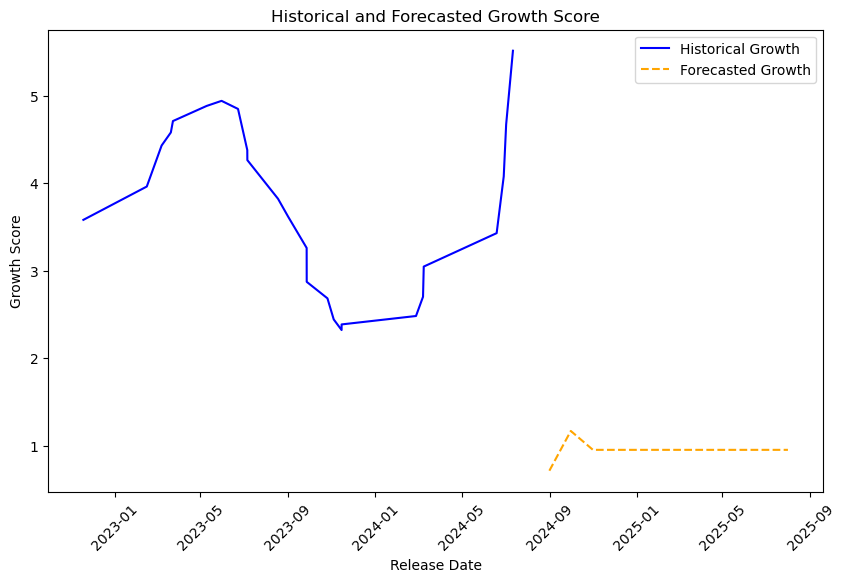

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the index is in datetime format (if not already)
test_df.index = pd.to_datetime(test_df.index)

# Historical data: Plot the actual release dates with the growth score
historical_growth = test_df['growth_score']

# Generate future dates for the forecasted values based on the release_date index
# If you are forecasting 'n_steps' into the future (assuming monthly intervals)
forecasted_dates = pd.date_range(start=test_df.index[-1], periods=n_forecast_steps + 1, freq='M')[1:]

# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, historical_growth, label='Historical Growth', color='blue')

# Plot forecasted data: Aligning the forecasted growth with future dates
plt.plot(forecasted_dates, forecasted_values, label='Forecasted Growth', color='orange', linestyle='--')

# Add labels and title
plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.title('Historical and Forecasted Growth Score')

# Add legend for clarity
plt.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [12]:
forecasted_values

array([0.7160885, 1.1701375, 0.9544094, 0.9544094, 0.9544094, 0.9544094,
       0.9544094, 0.9544094, 0.9544094, 0.9544094, 0.9544094, 0.9544094],
      dtype=float32)